In [11]:
# Install necessary packages
!pip install -q tensorflow==2.13.0 pandas numpy coremltools joblib matplotlib scikit-learn

# Imports
import json
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import coremltools as ct
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [12]:
# Load the data
with open('cycling_data2.json', 'r') as f:
    data = json.load(f)

# Define gear ratios and wheel circumference
gear_ratios = {
    1: 38.0 / 11.0,
    2: 38.0 / 15.0,
    3: 38.0 / 18.0,
    4: 38.0 / 21.0,
    5: 38.0 / 24.0,
    6: 38.0 / 34.0,
    # Add all your gear ratios here
}
wheel_circumference = 2.19999  # in meters

# Flatten the data and recalculate cadence
records = []
for session in data:
    for point in session['data']:
        gear = point['gear']
        speed = point['speed']  # in m/s
        gear_ratio = gear_ratios.get(gear, None)
        if gear_ratio and speed > 0:
            cadence = (speed / wheel_circumference) * gear_ratio * 60
        else:
            cadence = 0.0
        point['cadence'] = cadence
        records.append({
            'timestamp': point['timestamp'],
            'accel_x': point['accelerometerData']['x'],
            'accel_y': point['accelerometerData']['y'],
            'accel_z': point['accelerometerData']['z'],
            'speed': speed,
            'cadence': cadence,
            'gear': gear,
            'terrain': point['terrain'],
            'is_standing': point['isStanding']
        })

# Convert to DataFrame and ensure temporal order
df = pd.DataFrame(records)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values('timestamp', inplace=True)
df.reset_index(drop=True, inplace=True)


In [14]:
from sklearn.preprocessing import LabelEncoder

# Define window size and step
window_size = 100  # Number of time steps per sequence (e.g., 2 seconds at 50Hz)
step = 10  # Smaller step for more frequent predictions

# Features to use
feature_cols = ['accel_x', 'accel_y', 'accel_z']

# Scale accelerometer data
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# Encode Terrain and Stance
terrain_encoder = LabelEncoder()
df['terrain_encoded'] = terrain_encoder.fit_transform(df['terrain'])

stance_encoder = LabelEncoder()
df['is_standing_encoded'] = stance_encoder.fit_transform(df['is_standing'])

# Number of classes
num_terrain_classes = len(terrain_encoder.classes_)
num_stance_classes = len(stance_encoder.classes_)

# Prepare sequences and labels
sequences = []
cadence_labels = []
terrain_labels = []
stance_labels = []

for start in range(0, len(df) - window_size, step):
    end = start + window_size
    seq = df[feature_cols].iloc[start:end].values
    # Use the mean cadence over the window as the label
    cadence_label = df['cadence'].iloc[start:end].mean()
    # Use the most frequent terrain and stance in the window
    terrain_label = df['terrain_encoded'].iloc[start:end].mode()[0]
    stance_label = df['is_standing_encoded'].iloc[start:end].mode()[0]
    
    sequences.append(seq)
    cadence_labels.append(cadence_label)
    terrain_labels.append(terrain_label)
    stance_labels.append(stance_label)

sequences = np.array(sequences)
cadence_labels = np.array(cadence_labels)
terrain_labels = np.array(terrain_labels)
stance_labels = np.array(stance_labels)

print(f"Sequences shape: {sequences.shape}")
print(f"Cadence labels shape: {cadence_labels.shape}")
print(f"Terrain labels shape: {terrain_labels.shape}")
print(f"Stance labels shape: {stance_labels.shape}")


Sequences shape: (19580, 100, 3)
Cadence labels shape: (19580,)
Terrain labels shape: (19580,)
Stance labels shape: (19580,)


In [15]:
# Since this is time-series data, we avoid shuffling
total_samples = len(sequences)
train_size = int(total_samples * 0.7)
val_size = int(total_samples * 0.15)
test_size = total_samples - train_size - val_size

X_train = sequences[:train_size]
y_train_cadence = cadence_labels[:train_size]
y_train_terrain = terrain_labels[:train_size]
y_train_stance = stance_labels[:train_size]

X_val = sequences[train_size:train_size+val_size]
y_val_cadence = cadence_labels[train_size:train_size+val_size]
y_val_terrain = terrain_labels[train_size:train_size+val_size]
y_val_stance = stance_labels[train_size:train_size+val_size]

X_test = sequences[train_size+val_size:]
y_test_cadence = cadence_labels[train_size+val_size:]
y_test_terrain = terrain_labels[train_size+val_size:]
y_test_stance = stance_labels[train_size+val_size:]

print(f"Training sequences: {X_train.shape}")
print(f"Validation sequences: {X_val.shape}")
print(f"Testing sequences: {X_test.shape}")


Training sequences: (13706, 100, 3)
Validation sequences: (2937, 100, 3)
Testing sequences: (2937, 100, 3)


In [24]:
# Build the LSTM model
input_layer = Input(shape=(window_size, len(feature_cols)), name='accelerometer_input')

x = LSTM(32)(input_layer)
x = Dense(16, activation='relu')(x)
# Remove Dropout layer
# x = Dropout(0.2)(x)

# Output layers
cadence_output = Dense(1, name='cadence_output')(x)  # Regression output
terrain_output = Dense(num_terrain_classes, activation='softmax', name='terrain_output')(x)  # Classification output
stance_output = Dense(num_stance_classes, activation='softmax', name='stance_output')(x)  # Classification output

model = Model(inputs=input_layer, outputs=[cadence_output, terrain_output, stance_output])

# Compile the model with appropriate loss functions
model.compile(
    optimizer='adam',
    loss={
        'cadence_output': 'mse',
        'terrain_output': 'sparse_categorical_crossentropy',
        'stance_output': 'sparse_categorical_crossentropy'
    },
    metrics={
        'cadence_output': ['mae'],
        'terrain_output': ['accuracy'],
        'stance_output': ['accuracy']
    }
)


In [25]:
# Train the model
history = model.fit(
    X_train,
    {
        'cadence_output': y_train_cadence,
        'terrain_output': y_train_terrain,
        'stance_output': y_train_stance
    },
    epochs=20,
    batch_size=32,
    validation_data=(
        X_val,
        {
            'cadence_output': y_val_cadence,
            'terrain_output': y_val_terrain,
            'stance_output': y_val_stance
        }
    )
)


Epoch 1/20
429/429 [==============================] - 6s 12ms/step - loss: 46.6350 - cadence_output_loss: 46.2946 - terrain_output_loss: 0.0000e+00 - stance_output_loss: 0.3404 - cadence_output_mae: 3.9913 - terrain_output_accuracy: 0.0000e+00 - stance_output_accuracy: 0.9102 - val_loss: 12.5205 - val_cadence_output_loss: 12.3949 - val_terrain_output_loss: 0.0000e+00 - val_stance_output_loss: 0.1256 - val_cadence_output_mae: 2.2761 - val_terrain_output_accuracy: 0.0000e+00 - val_stance_output_accuracy: 1.0000
Epoch 2/20
429/429 [==============================] - 5s 11ms/step - loss: 25.6803 - cadence_output_loss: 25.4677 - terrain_output_loss: 0.0000e+00 - stance_output_loss: 0.2126 - cadence_output_mae: 2.8279 - terrain_output_accuracy: 0.0000e+00 - stance_output_accuracy: 0.9294 - val_loss: 12.7990 - val_cadence_output_loss: 12.7077 - val_terrain_output_loss: 0.0000e+00 - val_stance_output_loss: 0.0913 - val_cadence_output_mae: 2.3116 - val_terrain_output_accuracy: 0.0000e+00 - val_s

In [26]:
from sklearn.metrics import accuracy_score

# Evaluate on test set
test_results = model.evaluate(
    X_test,
    {
        'cadence_output': y_test_cadence,
        'terrain_output': y_test_terrain,
        'stance_output': y_test_stance
    },
    batch_size=32
)

# Predict on test set
y_pred_cadence, y_pred_terrain, y_pred_stance = model.predict(X_test)

# Flatten predictions
y_pred_cadence = y_pred_cadence.flatten()
y_pred_terrain = np.argmax(y_pred_terrain, axis=1)
y_pred_stance = np.argmax(y_pred_stance, axis=1)

# Metrics for Cadence
mae_cadence = mean_absolute_error(y_test_cadence, y_pred_cadence)
rmse_cadence = np.sqrt(mean_squared_error(y_test_cadence, y_pred_cadence))
print(f'MAE on test set (Cadence): {mae_cadence:.2f}')
print(f'RMSE on test set (Cadence): {rmse_cadence:.2f}')

# Metrics for Terrain
accuracy_terrain = accuracy_score(y_test_terrain, y_pred_terrain)
print(f'Accuracy on test set (Terrain): {accuracy_terrain:.2%}')

# Metrics for Stance
accuracy_stance = accuracy_score(y_test_stance, y_pred_stance)
print(f'Accuracy on test set (Stance): {accuracy_stance:.2%}')


92/92 [==============================] - 0s 3ms/step
MAE on test set (Cadence): 3.10
RMSE on test set (Cadence): 5.69
Accuracy on test set (Terrain): 100.00%
Accuracy on test set (Stance): 98.60%



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


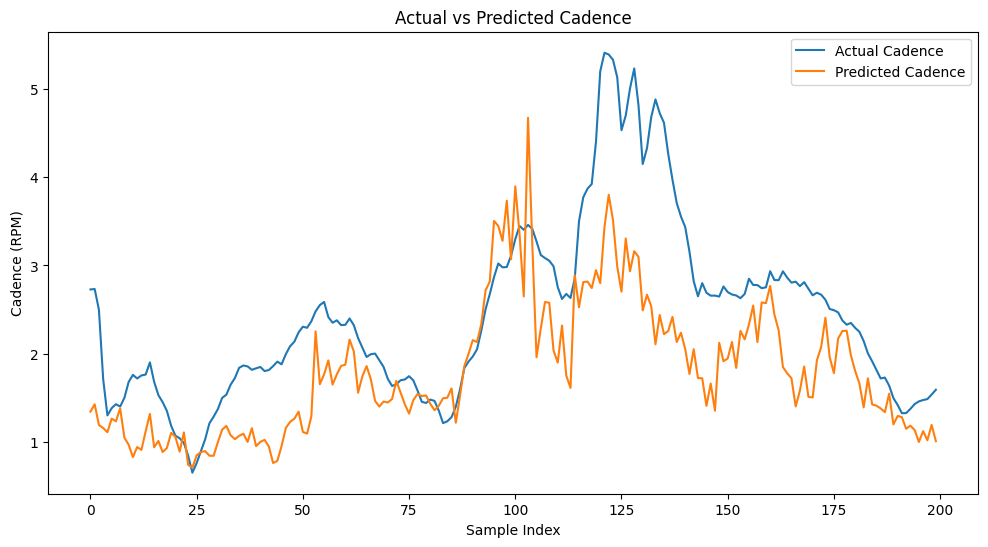

/Users/lj321/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 4/IoT/IOT3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


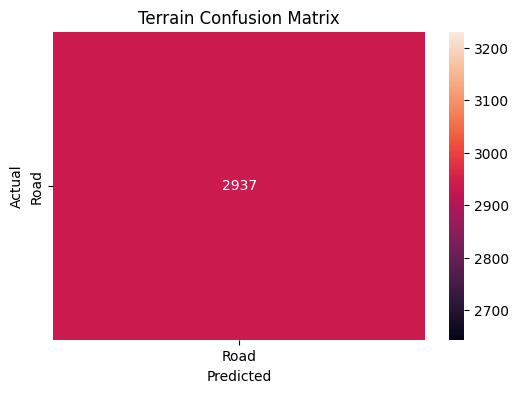

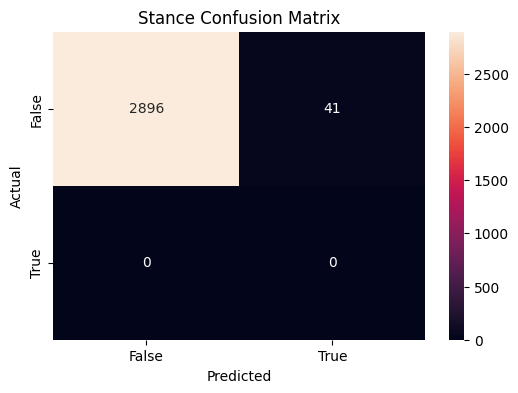

In [27]:

# Install seaborn
%pip install seaborn

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot actual vs. predicted cadence
plt.figure(figsize=(12, 6))
plt.plot(y_test_cadence[:200], label='Actual Cadence')
plt.plot(y_pred_cadence[:200], label='Predicted Cadence')
plt.legend()
plt.title('Actual vs Predicted Cadence')
plt.xlabel('Sample Index')
plt.ylabel('Cadence (RPM)')
plt.show()

# Confusion Matrix for Terrain
cm_terrain = confusion_matrix(y_test_terrain, y_pred_terrain)
plt.figure(figsize=(6,4))
sns.heatmap(cm_terrain, annot=True, fmt='d', xticklabels=terrain_encoder.classes_, yticklabels=terrain_encoder.classes_)
plt.title('Terrain Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion Matrix for Stance
cm_stance = confusion_matrix(y_test_stance, y_pred_stance)
plt.figure(figsize=(6,4))
sns.heatmap(cm_stance, annot=True, fmt='d', xticklabels=stance_encoder.classes_, yticklabels=stance_encoder.classes_)
plt.title('Stance Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [30]:
import coremltools as ct

# Convert the model to Core ML format
input_shape = (1, window_size, len(feature_cols))  # Specify a fixed batch size of 1
input_name = 'accelerometer_input'

# Convert the model to Core ML format
mlmodel = ct.convert(
    model,
    inputs=[ct.TensorType(name=input_name, shape=input_shape)],
    source='tensorflow',
    minimum_deployment_target=ct.target.iOS15  # Adjust based on your deployment target
)

# Save the Core ML model
mlmodel.save('CyclingPredictor.mlpackage')
print("Model converted and saved to 'CyclingPredictor.mlpackage'")


Converting TF Frontend ==> MIL Ops: 100%|██████████| 14/14 [00:00<00:00, 54674.35 ops/s]
Input ls elem type unknown. Override with <class 'coremltools.converters.mil.mil.types.type_tensor.tensor.<locals>.tensor'>
Converting TF Frontend ==> MIL Ops: 100%|██████████| 14/14 [00:00<00:00, 86864.28 ops/s]
Input ls elem type unknown. Override with <class 'coremltools.converters.mil.mil.types.type_tensor.tensor.<locals>.tensor'>
Converting TF Frontend ==> MIL Ops: 100%|██████████| 41/41 [00:00<00:00, 23696.63 ops/s]
Saving value type of int64 into a builtin type of int32, might lose precision!
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 1738.63 passes/s]


Model converted and saved to 'CyclingPredictor.mlpackage'


In [41]:
# Load the Core ML model
mlmodel = ct.models.MLModel('CyclingPredictor.mlpackage')

# Prepare a sample input
sample_input = X_test[0]  # Shape: (window_size, 3)

# Core ML expects input in a specific format
input_data = {input_name: sample_input[np.newaxis, :, :].astype(np.float32)}

# Run prediction
output = mlmodel.predict(input_data)

# Print the keys of the output dictionary to debug
print(output.keys())

# Extract predictions using the correct keys
predicted_cadence = output['Identity'][0]
predicted_terrain = np.argmax(output['Identity_1'][0])
predicted_stance = np.argmax(output['Identity_2'][0])

print(f"Predicted Cadence: {predicted_cadence}")
print(f"Actual Cadence: {y_test_cadence[0]}")

print(f"Predicted Terrain: {terrain_encoder.inverse_transform([predicted_terrain])[0]}")
print(f"Actual Terrain: {terrain_encoder.inverse_transform([y_test_terrain[0]])[0]}")

print(f"Predicted Stance: {stance_encoder.inverse_transform([predicted_stance])[0]}")
print(f"Actual Stance: {stance_encoder.inverse_transform([y_test_stance[0]])[0]}")


dict_keys(['Identity_1', 'Identity_2', 'Identity'])
Predicted Cadence: [1.3427734]
Actual Cadence: 2.728336497454357
Predicted Terrain: Road
Actual Terrain: Road
Predicted Stance: False
Actual Stance: False


In [42]:
# Save the scaler parameters
import joblib
joblib.dump(scaler, 'scaler.save')
print("Scaler saved to 'scaler.save'")


Scaler saved to 'scaler.save'
